In [30]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os

BASE_DIR = "/home/aarushg/KAN-FPGA/benchmarks/hls4ml_jets"

# Get all CSV files from logs directory
csv_files = glob.glob(f'{BASE_DIR}/logs/res*_gr*_tp*_fp*_pr*.txt')

# Read and concatenate all CSV files
df_list = []
for file in csv_files:
    df = pd.read_csv(file)
    # Extract prune ratio from filename
    pr_start = file.find('_pr') + 3
    pr_end = file.find('.txt')
    prune_ratio = float(file[pr_start:pr_end])
    df['pr'] = prune_ratio
    if 'FF' not in df.columns or 'LUT' not in df.columns:
        continue
    df_list.append(df)

df = pd.concat(df_list, ignore_index=True)

# Calculate accuracy
df['accuracy'] = df['correct'] / df['total']

# Create subplots for each parameter
parameters = [col for col in df.columns if col not in ['correct', 'total', 'accuracy', 'Modules&Loops', 'Slack', 'Interval', 'Pipelined', 'Latency(ns)', 'Latency(cycles)', 'FF', 'LUT']]

# Keep only parameters and resource usage columns
columns_to_keep = parameters + ['FF', 'LUT'] 
df = df[columns_to_keep]
print(df)



     res  tp  fp   pr    FF   LUT
0     64   4   2  0.0   419  1341
1     64   4   2  0.2   406  1158
2     64   4   2  0.4   344   973
3     64   4   2  0.6   246   690
4     64   4   2  0.8    70   253
..   ...  ..  ..  ...   ...   ...
310  256  12   6  0.0  1167  5352
311  256  12   6  0.2  1015  4663
312  256  12   6  0.4   834  3614
313  256  12   6  0.6   545  2526
314  256  12   6  0.8   175   968

[315 rows x 6 columns]


['tp', 'fp', 'pr']
HI    tp  fp   pr
0   4   2  0.0
1   4   2  0.2
2   4   2  0.4
3   4   2  0.6
4   4   2  0.8
   tp  fp   pr
0   4   2  0.0
1   4   2  0.2
2   4   2  0.4
3   4   2  0.6
4   4   2  0.8
     res  tp  fp   pr   FF   LUT
0     64   4   2  0.0  419  1341
105  128   4   2  0.0  476  1623
210  256   4   2  0.0  421  2183
['res', 'fp', 'pr']
HI    res  fp   pr
0   64   2  0.0
1   64   2  0.2
2   64   2  0.4
3   64   2  0.6
4   64   2  0.8
   res  fp   pr
0   64   2  0.0
1   64   2  0.2
2   64   2  0.4
3   64   2  0.6
4   64   2  0.8
    res  tp  fp   pr   FF   LUT
0    64   4   2  0.0  419  1341
10   64   6   2  0.0  536  1373
30   64   8   2  0.0  518  1277
55   64  10   2  0.0  518  1277
80   64  12   2  0.0  518  1277
['res', 'tp', 'pr']
HI    res  tp   pr
0   64   4  0.0
1   64   4  0.2
2   64   4  0.4
3   64   4  0.6
4   64   4  0.8
   res  tp   pr
0   64   4  0.0
1   64   4  0.2
2   64   4  0.4
3   64   4  0.6
4   64   4  0.8
    res  tp  fp   pr    FF   LUT
30   64   8

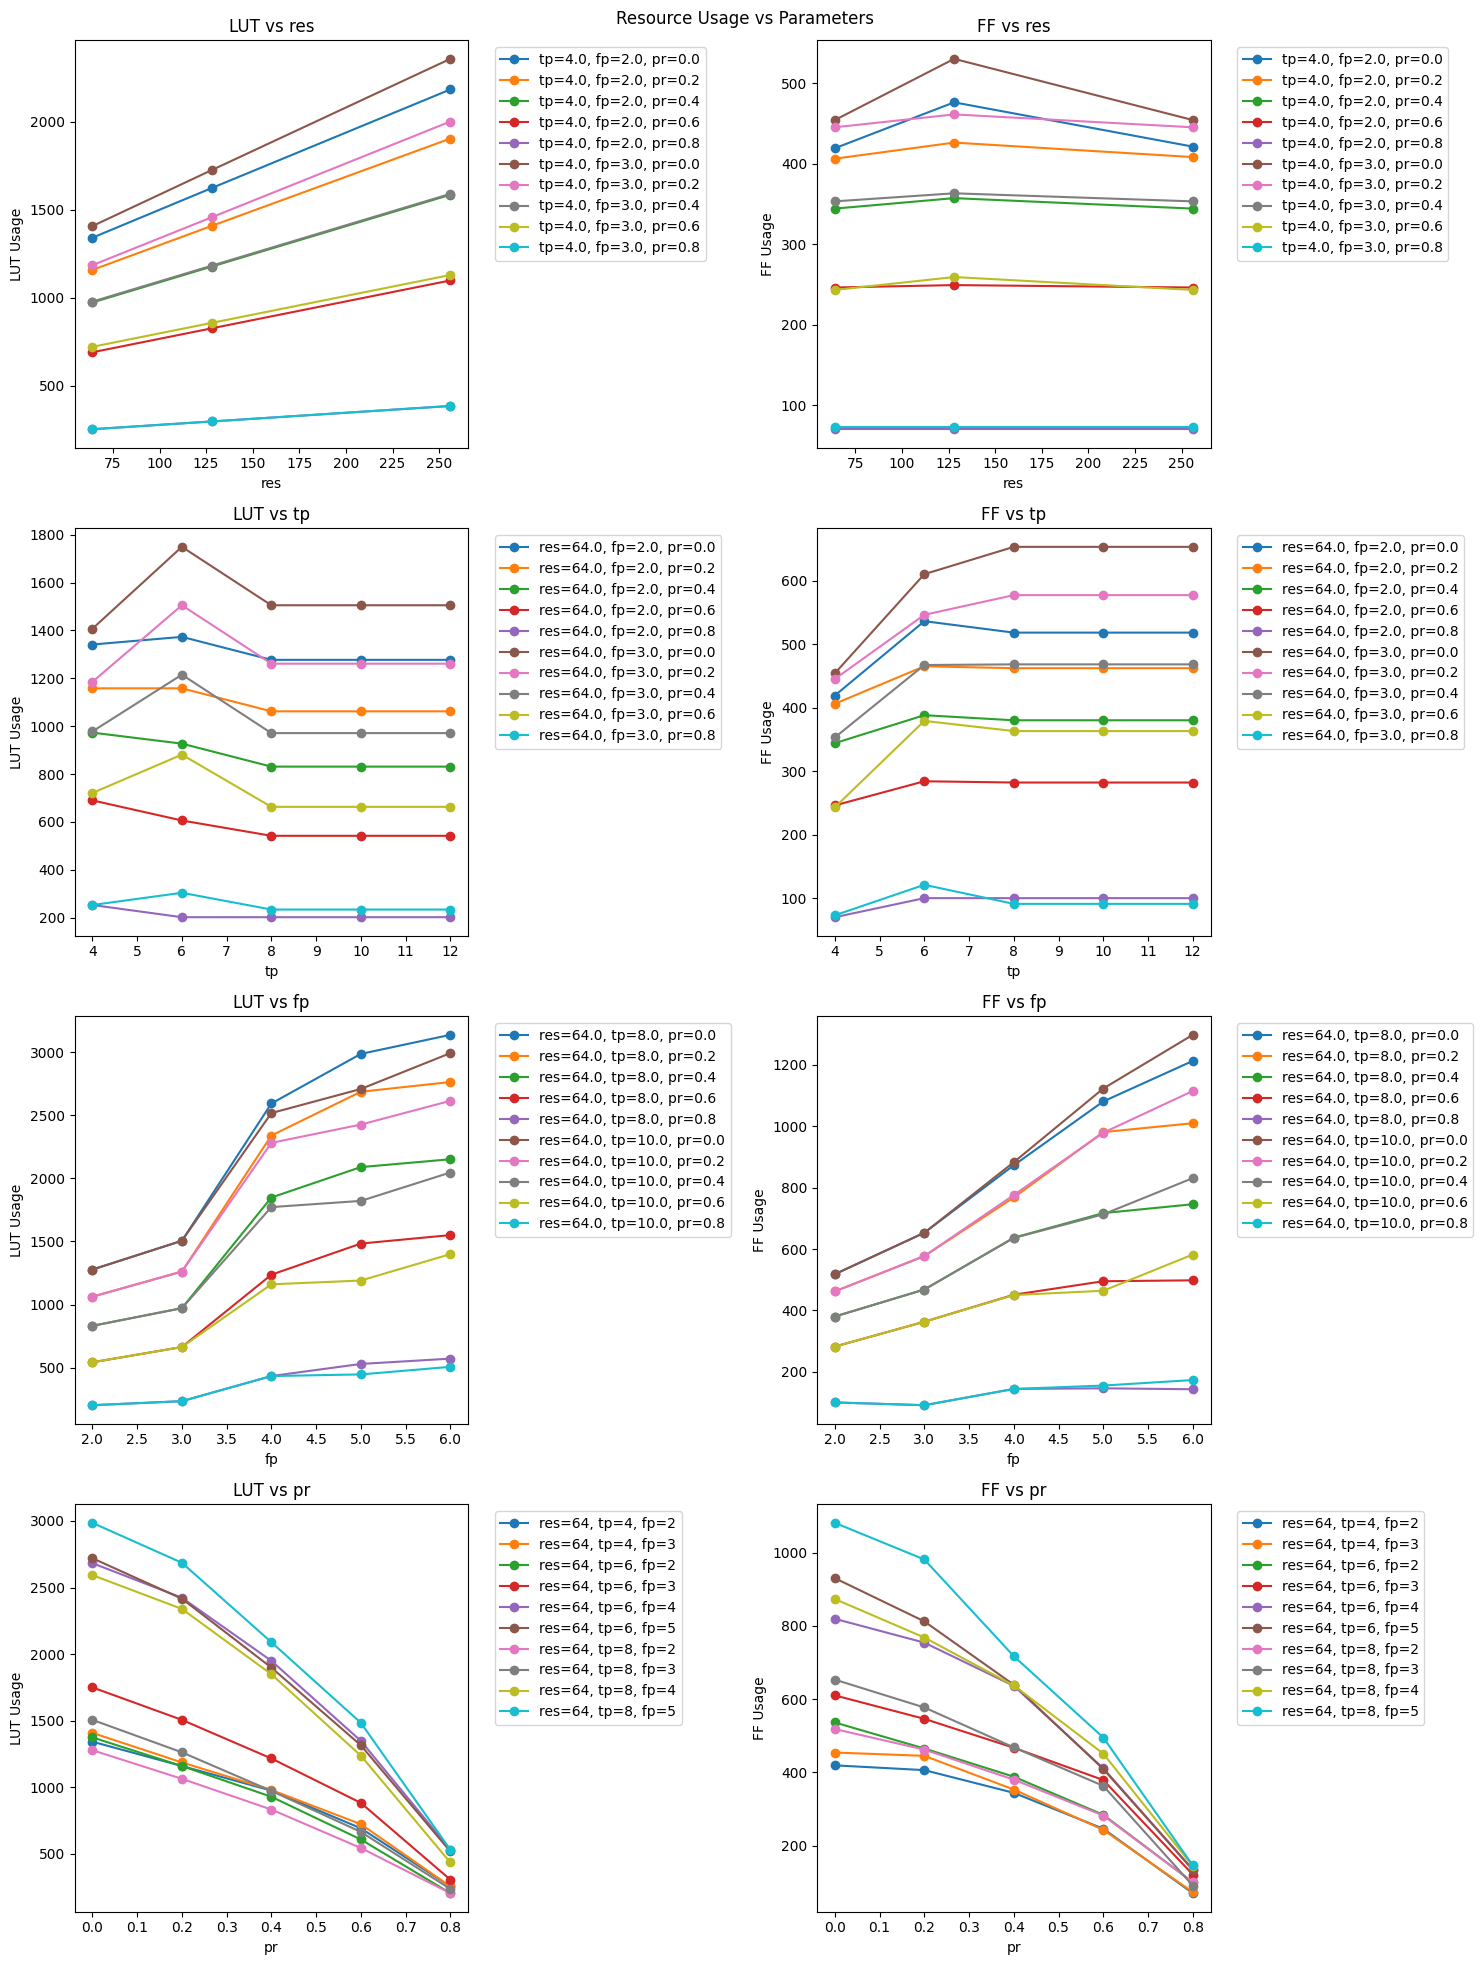

In [32]:
# Create a figure for each parameter showing how LUT and FF vary
fig, axs = plt.subplots(len(parameters), 2, figsize=(15, 5*len(parameters)))
fig.suptitle('Resource Usage vs Parameters')

for i, param in enumerate(parameters):
    # Get all unique combinations of other parameters
    other_params = [p for p in parameters if p != param]

    print(other_params)
    print("HI", df[other_params].head())

    param_combinations = df[other_params].drop_duplicates()

    print(param_combinations.head())
    
    # Create list of dataframes for each parameter combination
    param_dfs = []
    for _, combo in param_combinations.iterrows():
        mask = True
        for other_param, value in combo.items():
            mask = mask & (df[other_param] == value)
        param_dfs.append(df[mask])

    # Sample combinations with most rows
    param_dfs_with_size = [(df, len(df)) for df in param_dfs]
    param_dfs_with_size.sort(key=lambda x: x[1], reverse=True)
    sampled_indices = min(10, len(param_dfs))
    sampled_dfs = [df for df, _ in param_dfs_with_size[:sampled_indices]]

    print(sampled_dfs[0].head())
    
    # Plot LUT usage
    for df_subset in sampled_dfs:
        df_subset = df_subset.sort_values(by=param)
        if not df_subset.empty:
            label = ', '.join([f'{p}={v}' for p,v in df_subset[other_params].iloc[0].items()])
            axs[i,0].plot(df_subset[param], df_subset['LUT'], marker='o', label=label, linestyle='-')
    
    axs[i,0].set_title(f'LUT vs {param}')
    axs[i,0].set_xlabel(param)
    axs[i,0].set_ylabel('LUT Usage')
    axs[i,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot FF usage
    for df_subset in sampled_dfs:
        df_subset = df_subset.sort_values(by=param)
        if not df_subset.empty:
            label = ', '.join([f'{p}={v}' for p,v in df_subset[other_params].iloc[0].items()])
            axs[i,1].plot(df_subset[param], df_subset['FF'], marker='o', label=label, linestyle='-')
    
    axs[i,1].set_title(f'FF vs {param}')
    axs[i,1].set_xlabel(param)
    axs[i,1].set_ylabel('FF Usage')
    axs[i,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
print(parameters)

fig, axs = plt.subplots((len(parameters) + 2), 1, figsize=(10, 5*(len(parameters) + 2)))
# Plot accuracy vs each parameter
for i, param in enumerate(parameters + ['FF', 'LUT']):
    sns.scatterplot(data=df, x=param, y='accuracy', ax=axs[i])
    axs[i].set_title(f'Accuracy vs {param}')
    axs[i].set_xlabel(param)
    axs[i].set_ylabel('Accuracy')



plt.tight_layout()
plt.show()


fig, axs = plt.subplots(len(parameters), 1, figsize=(10, 5*(len(parameters) + 2)))

print(parameters)

# Plot accuracy vs each parameter
for i, param in enumerate(parameters):
    sns.scatterplot(data=df, x=param, y='FF', ax=axs[i])
    sns.scatterplot(data=df, x=param, y='LUT', ax=axs[i])
    axs[i].set_title(f'FF / LUT vs {param}')
    axs[i].set_xlabel(param)
    axs[i].set_ylabel('FF / LUT usage')



plt.tight_layout()
plt.show()